# Replicate Value Function Iteration (VFI) from Fernandez-Villaverde (2018)
- Paper: https://www.sas.upenn.edu/~jesusfv/Guide_Parallel.pdf
- VFI logic modfied based on https://github.com/davidzarruk/Parallel_Computing/blob/master/Python_main.py  
- Parameters nx=350 and ne=9 are taken from paper 

In [1]:
#--------------------------------#
#         House-keeping          #
#--------------------------------#
import random
import numpy
import math
import time
from scipy.stats import norm
from joblib import Parallel, delayed
import multiprocessing
import sys

#--------------------------------#
#         Initialization         #
#--------------------------------#

# Number of workers
num_cores = int(10);

# Grid for x
nx            = 350; 
xmin          = 0.1;
xmax          = 4.0;

# Grid for e: parameters for Tauchen
ne            = 9;
ssigma_eps    = 0.02058;
llambda_eps   = 0.99;
m             = 1.5;

# Utility function
ssigma        = 2;
bbeta         = 0.97;
T             = 10;

# Prices
r             = 0.07;
w             = 5;

# Initialize the grid for X
xgrid = numpy.zeros(nx)

# Initialize the grid for E and the transition probability matrix
egrid = numpy.zeros(ne)
P     = numpy.zeros((ne, ne))

# Initialize value function V
V     = numpy.zeros((T, nx, ne))
Reward = numpy.zeros((T, nx, ne))
X_state = numpy.zeros((T, nx, ne))
X_next_state = numpy.zeros((T, nx, ne))
E_state = numpy.zeros((T, nx, ne))

#--------------------------------#
#         Grid creation          #
#--------------------------------#

# Function to construct the grid for capital (x)
size = nx;
xstep = (xmax - xmin) /(size - 1);
it = 0;
for i in range(0,nx):
    xgrid[i] = xmin + it*xstep;
    it = it+1;


# Function to construct the grid for productivity (e) using Tauchen (1986)
size = ne;
ssigma_y = math.sqrt(math.pow(ssigma_eps, 2) / (1 - math.pow(llambda_eps,2)));
estep = 2*ssigma_y*m / (size-1);
it = 0;
for i in range(0,ne):
    egrid[i] = (-m*math.sqrt(math.pow(ssigma_eps, 2) / (1 - math.pow(llambda_eps,2))) + it*estep);
    it = it+1;


# Function to construct the transition probability matrix for productivity (P) using Tauchen (1986)
mm = egrid[1] - egrid[0];
for j in range(0,ne):
    for k in range(0,ne):
        if (k == 0):
            P[j, k] = norm.cdf((egrid[k] - llambda_eps*egrid[j] + (mm/2))/ssigma_eps);
        elif (k == ne-1):
            P[j, k] = 1 - norm.cdf((egrid[k] - llambda_eps*egrid[j] - (mm/2))/ssigma_eps);
        else:
            P[j, k] = norm.cdf((egrid[k] - llambda_eps*egrid[j] + (mm/2))/ssigma_eps) - norm.cdf((egrid[k] - llambda_eps*egrid[j] - (mm/2))/ssigma_eps);


# Exponential of the grid e
for i in range(0,ne):
    egrid[i] = math.exp(egrid[i]);



#--------------------------------#
#     Structure and function     #
#--------------------------------#

# Value function
VV = math.pow(-10.0, 5);

In [2]:
# Data structure of state and exogenous variables
class modelState(object):
	def __init__(self,ind,ne,nx,T,age,P,xgrid,egrid,ssigma,bbeta,w,r):
		self.ind		= ind
		self.ne			= ne
		self.nx			= nx
		self.T			= T
		self.age		= age
		self.P			= P
		self.xgrid		= xgrid
		self.egrid		= egrid
		self.ssigma		= ssigma
		self.bbeta		= bbeta
		self.w			= w
		self.r			= r

# Function that returns value for a given state
# ind: a unique state that corresponds to a pair (ie,ix)
def value_func(states):

	ind = states.ind
	ne = states.ne
	nx = states.nx
	T = states.T
	age = states.age
	P = states.P
	xgrid = states.xgrid
	egrid = states.egrid
	ssigma = states.ssigma
	bbeta = states.bbeta
	w = states.w
	r = states.r

	ix = int(math.floor(ind/ne));
	ie = int(math.floor(ind%ne));

	VV = math.pow(-10.0, 3)
	for ixp in range(0,nx):
		expected = 0.0;
		if(age < T-1):
			for iep in range(0,ne):
				expected = expected + P[ie, iep]*V[age+1, ixp, iep]

		cons  = (1 + r)*xgrid[ix] + egrid[ie]*w - xgrid[ixp];

		x = xgrid[ix] 
		e = egrid[ie]  
		x_next = xgrid[ixp]  
		reward = math.pow(cons, (1-ssigma))/(1-ssigma)
		utility = reward + bbeta*expected;        
		if(cons <= 0):
			reward = math.pow(-10.0,5);
			utility = math.pow(-10.0,5);
		
		if(utility >= VV):
			RR = reward;
			VV = utility;
			XX = x;
			EE = e;
			XX_next = x_next;
            
		reward = 0.0;
		utility = 0.0;
        
	return [VV, RR, XX, EE, XX_next];
	#return [VV];

In [3]:
#--------------------------------#
#     Life-cycle computation     #
#--------------------------------#

print("There is compelling evidence to support the second prediction of the")
print("Life cycle computation: ")
print(" ")


start = time.time()

for age in reversed(range(0,T)):

    # This function computes `value_func` in parallel for all the states
    results = Parallel(n_jobs=num_cores)(delayed(value_func)(modelState(ind,ne,nx,T,age,P,xgrid,egrid,ssigma,bbeta,w,r)) for ind in range(0,nx*ne))

    # I write the results on the value matrix: V
    for ind in range(0,nx*ne):
        
        ix = int(math.floor(ind/ne));
        ie = int(math.floor(ind%ne));

        V[age, ix, ie] = results[ind][0];
        Reward[age, ix, ie] = results[ind][1];
        X_state[age, ix, ie] = results[ind][2];
        E_state[age, ix, ie] = results[ind][3];
        X_next_state[age, ix, ie] = results[ind][4];
        
    finish = time.time() - start
    print("Age: ", age+1, ". Time: ", round(finish, 4), " seconds.")

finish = time.time() - start
print("TOTAL ELAPSED TIME: ", round(finish, 4), " seconds. \n")

There is compelling evidence to support the second prediction of the
Life cycle computation: 
 
Age:  10 . Time:  1.0245  seconds.
Age:  9 . Time:  2.5663  seconds.
Age:  8 . Time:  4.1402  seconds.
Age:  7 . Time:  5.7075  seconds.
Age:  6 . Time:  7.3019  seconds.
Age:  5 . Time:  8.9064  seconds.
Age:  4 . Time:  10.5856  seconds.
Age:  3 . Time:  12.2262  seconds.
Age:  2 . Time:  13.843  seconds.
Age:  1 . Time:  15.5005  seconds.
TOTAL ELAPSED TIME:  15.5007  seconds. 



# Evaluate Results against Deep Reinforcement Learning Approach
## Create dataframe with total episode reward (discounted utility) for 
- Deep Reinforcement Learning (DRL)
- Value Function Interation (VFI)

In [ ]:
import numpy as np
import pandas as pd

file_path = '/opt/ml/output/data/macroeconomic.csv'
df_raw = pd.read_csv(file_path)

cols = ['episode', 'reward_drl', 'reward_vfi', 'x0', 'shocks']
df_rewards = pd.DataFrame(columns=cols)

epsiode_min = 1 
episode_max = len(df_raw['episode'].unique())

for episode in range(epsiode_min, episode_max):
    if episode % 1000 == 0:
        print(episode)
        
    df_tmp = df_raw.loc[df_raw['episode'] == episode]
    if len(df_tmp) > 0:
        t_list = list(range(0, T))
        e_list = df_tmp['e'].tolist()
        x_next = df_tmp['x'].values[0]

        # create reward for VFI for given set of shocks from DRL episode
        total_reward = []
        for t_idx, e in zip(range(0,T), e_list):
            x = x_next
            x_idx = np.where(np.round(xgrid, 10) == np.round(x, 10))[0][0]
            e_idx = np.where(np.round(egrid, 10) == np.round(e, 10))[0][0]
            reward = Reward[t_idx, x_idx, e_idx]
            x_next = X_next_state[t_idx, x_idx, e_idx]
            cons  = (1 + r)*x + e*w - x_next
            total_reward.append(reward)

        # save results to Dataframe
        reward_DRL = np.sum(df_tmp['reward'])
        reward_VFI = np.sum(total_reward)       
        df_rewards_tmp = pd.DataFrame(columns=cols)
        x0 = df_tmp['x'].values[0]
        df_rewards_tmp.loc[0] = [episode, reward_DRL, reward_VFI, x0, e_list]
        df_rewards = df_rewards.append(df_rewards_tmp, ignore_index=True)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000


## Add rolling mean over last 1000 episodes

In [5]:
df_rewards_plot = df_rewards
df_rewards_plot['reward_drl_rolling'] = df_rewards_plot['reward_drl'].rolling(1000).mean()
df_rewards_plot['reward_vfi_rolling'] = df_rewards_plot['reward_vfi'].rolling(1000).mean()

## Create comparsion plot

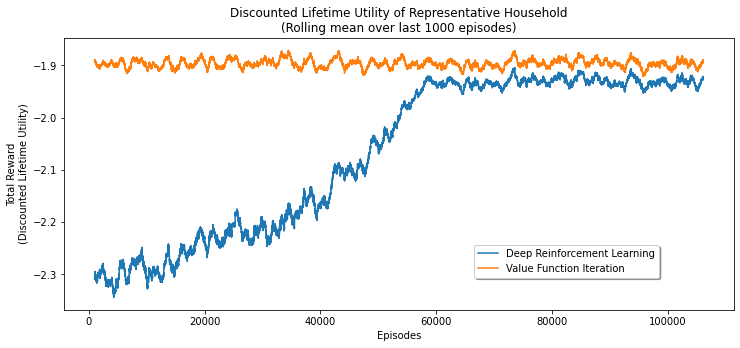

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf


x = df_rewards_plot['episode']
y1 = df_rewards_plot['reward_drl_rolling']
y2 = df_rewards_plot['reward_vfi_rolling']
x_axis = 'episode'
y_axis1 = 'reward_drl_rolling'
y_axis2 = 'reward_vfi_rolling'

plt.plot(x, y1, label = 'Deep Reinforcement Learning')
plt.plot(x, y2, label = 'Value Function Iteration')

plt.ylabel('Total Reward\n(Discounted Lifetime Utility)')
plt.xlabel('Episodes')
plt.title('Discounted Lifetime Utility of Representative Household\n(Rolling mean over last 1000 episodes)')
plt.legend(loc='lower center', bbox_to_anchor=(0.75, +0.1), ncol=1, fancybox=True, shadow=True)
fig = gcf()
fig.set_size_inches(12, 5)
# plt.show()
fig.savefig('utility_lifecycle_model.png', dpi=100)

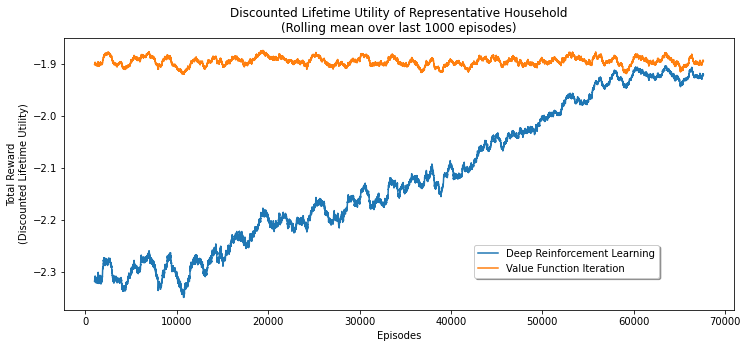

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf


x = df_rewards_plot['episode']
y1 = df_rewards_plot['reward_drl_rolling']
y2 = df_rewards_plot['reward_vfi_rolling']
x_axis = 'episode'
y_axis1 = 'reward_drl_rolling'
y_axis2 = 'reward_vfi_rolling'

plt.plot(x, y1, label = 'Deep Reinforcement Learning')
plt.plot(x, y2, label = 'Value Function Iteration')

plt.ylabel('Total Reward\n(Discounted Lifetime Utility)')
plt.xlabel('Episodes')
plt.title('Discounted Lifetime Utility of Representative Household\n(Rolling mean over last 1000 episodes)')
plt.legend(loc='lower center', bbox_to_anchor=(0.75, +0.1), ncol=1, fancybox=True, shadow=True)
fig = gcf()
fig.set_size_inches(12, 5)
# plt.show()
fig.savefig('utility_lifecycle_model.png', dpi=100)

In [7]:
pd.set_option('display.max_rows', 500)
df_rewards_plot['DIFF'] = df_rewards_plot['reward_vfi'] - df_rewards_plot['reward_drl']
df_rewards_plot.tail(100)

,episode,reward_drl,reward_vfi,x0,shocks,reward_drl_rolling,reward_vfi_rolling,DIFF
105600,106073,-1.842131,-1.833454,2.133811,"[1.056232051620802, 1.056232051620802, 1.0, 1....",-1.923943,-1.891824,0.008678
105601,106074,-1.702561,-1.662090,3.351862,"[1.1156261468710882, 1.1156261468710882, 1.115...",-1.923660,-1.891541,0.040472
105602,106075,-1.999351,-1.983264,2.524928,"[1.0, 1.0, 0.9467616500232946, 0.9467616500232...",-1.923901,-1.891797,0.016086
105603,106076,-1.880728,-1.849078,1.351576,"[1.0, 1.0, 1.0, 1.056232051620802, 1.056232051...",-1.924125,-1.892001,0.031649
105604,106077,-2.374713,-2.346454,0.424069,"[0.8486370211729126, 0.8486370211729126, 0.848...",-1.924581,-1.892445,0.028259
105605,106078,-1.855583,-1.836810,0.535817,"[1.056232051620802, 1.056232051620802, 1.05623...",-1.924014,-1.891893,0.018773
105606,106079,-1.661162,-1.634282,2.133811,"[1.1783600939514596, 1.1783600939514596, 1.178...",-1.923804,-1.891669,0.026879
105607,106080,-1.725797,-1.695825,1.418625,"[1.1156261468710882, 1.1156261468710882, 1.115...",-1.923796,-1.891647,0.029972
105608,106081,-1.919193,-1.907994,3.966476,"[0.8963576219548313, 0.8963576219548313, 0.896...",-1.923416,-1.891286,0.011199
105609,106082,-2.091913,-2.046998,1.172779,"[0.9467616500232946, 0.9467616500232946, 0.946...",-1.923578,-1.891421,0.044915


# Old Code for Q-Learning Experiments